Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [23]:
from random import random, seed
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm.auto import tqdm
import torch

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [24]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2
NSTEPS = 10000

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [25]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

SETS = torch.tensor(SETS, dtype=torch.bool)
COSTS = torch.tensor(COSTS, dtype=torch.float32)


## Helper Functions

In [26]:
"""
def valid(solution):
    #Checks wether solution is valid (ie. covers all universe)
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    #Returns the cost of a solution (to be minimized)
    return COSTS[solution].sum()

"""

def valid(solution: torch.Tensor, SETS: torch.Tensor) -> bool:
    """Checks whether the solution is valid (i.e., covers the entire universe) using PyTorch tensors."""
    selected_sets = SETS[solution]  # Get the sets indexed by the solution
    coverage = torch.any(selected_sets, dim=0)  # Check if any True across rows for each column
    return torch.all(coverage)  # Valid if all columns are covered (i.e., all True)


def cost(solution: torch.Tensor, COSTS: torch.Tensor) -> torch.Tensor:
    """Returns the cost of a solution (to be minimized) using PyTorch tensors."""
    return COSTS[solution].sum()


## Have Fun!

In [27]:
def generate_sets(UNIVERSE_SIZE: int, NUM_SETS: int, density: float):
    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * density)]))
    sets = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < density
    for s in range(UNIVERSE_SIZE):
        if not np.any(sets[:, s]):
            sets[np.random.randint(NUM_SETS), s] = True
    COSTS = np.pow(sets.sum(axis=1), 1.1)
    return (rng, sets, COSTS)

In [ ]:
"""
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), -cost(solution)
"""

In [29]:
def single_mutation_tweak(solution: np.ndarray) -> np.ndarray:
    """Tweaks the solution by flipping a random set, i.e. not taking it if it was taken and vice versa"""
    new_sol = solution.copy()
    idx = rng.integers(NUM_SETS)
    new_sol[idx] = not new_sol[idx]
    return new_sol

def multi_mutation_tweak(solution: np.ndarray) -> np.ndarray:

    new_sol = solution.copy()
    """Create a random mask of sets to be flipped and apply it to the solution,
        If the mask is True and the set is already taken -> true to false
        If the mask is True and the set is not taken -> false to true"""
    
    #while solution is the same as the new solution, keep generating new solutions
    while np.all(new_sol == solution):
        mask = rng.random(NUM_SETS) < 0.01
        new_sol = np.logical_xor(new_sol, mask)

    return new_sol
"""
def multi_tweak_no_mask(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    index = None
    while index is None or np.random.random() < 0.2:
        index = rng.integers(0, NUM_SETS)
        new_sol[index] = not new_sol[index]
    
    return new_sol

"""

# Convert np.ndarray to torch.Tensor
def numpy_to_torch_gpu(arr: np.ndarray) -> torch.Tensor:
    return torch.tensor(arr, device='cuda')

# Convert torch.Tensor to np.ndarray
def torch_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    return tensor.cpu().numpy()

def multi_tweak_no_mask(solution: torch.Tensor) -> torch.Tensor:
    new_sol = solution.clone()
    index = None
    while index is None or torch.rand(1).item() < 0.2:
        index = torch.randint(0, NUM_SETS, (1,)).item()
        new_sol[index] = not new_sol[index]
    
    return new_sol


In [30]:
"""
def fitness(solution: np.ndarray) -> float:
    #Returns the fitness of a solution
    return (valid(solution), -cost(solution))

"""
def fitness(solution: torch.Tensor, SETS: torch.Tensor, COSTS: torch.Tensor) -> tuple:
    """Returns the fitness of a solution using PyTorch tensors"""
    is_valid = valid(solution, SETS)
    solution_cost = -cost(solution, COSTS)
    return is_valid, solution_cost


## Hill Climber with random multi tweak

ic| fitness(solution, SETS, COSTS): (tensor(True, device='cuda:0'), tensor(-6549.6235, device='cuda:0'))
ic| valid(solution, SETS): tensor(True, device='cuda:0')


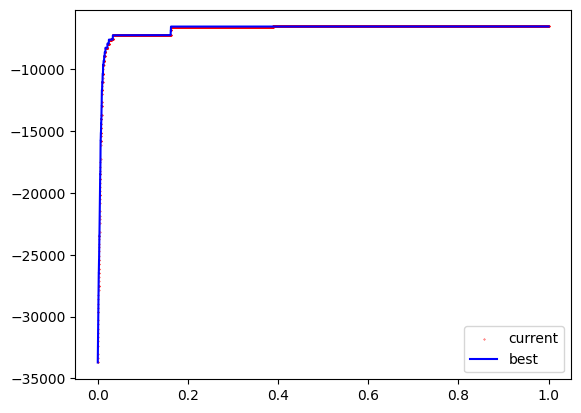

In [31]:


# Move SETS and COSTS to GPU
SETS = SETS.to('cuda')
COSTS = COSTS.to('cuda')

# Vector of all False
solution = rng.random(NUM_SETS) < 1  # Generate the initial solution
solution = numpy_to_torch_gpu(solution)  # Move solution to GPU

# Compute initial fitness
solution_fitness = fitness(solution, SETS, COSTS)

# Initialize history
full_history = [(-cost(solution, COSTS), 1)]
bettering_history = [(-cost(solution, COSTS), 1)]

# Tweak function is assumed to already work with PyTorch tensors
tweak = multi_tweak_no_mask

# Main loop
for steps in tqdm(range(NSTEPS)):
    new_solution = tweak(solution)
    full_history.append((-cost(solution, COSTS), 1))
    
    # If new solution is better than the last one, take it
    if fitness(new_solution, SETS, COSTS) > fitness(solution, SETS, COSTS):
        solution = new_solution
    
    bettering_history.append((-cost(solution, COSTS), 1))




ic(fitness(solution, SETS, COSTS))
ic(valid(solution, SETS))
# Convert full_history and bettering_history to NumPy (if they contain PyTorch tensors)
full_history_numpy = [(x[0].cpu().numpy() if isinstance(x[0], torch.Tensor) else x[0]) for x in full_history]
bettering_history_numpy = [(x[0].cpu().numpy() if isinstance(x[0], torch.Tensor) else x[0]) for x in bettering_history]

# Generate linspace for plotting
linspace_full = np.linspace(0, 1, len(full_history_numpy))  # Adjust linspace length for full history
linspace_bettering = np.linspace(0, 1, len(bettering_history_numpy))  # Adjust linspace length for bettering history

# Scatter plot for full history with reduced point size
plt.scatter(linspace_full, full_history_numpy, color='red', s=0.1)

# Line plot for bettering history
plt.plot(linspace_bettering, bettering_history_numpy, color='blue')
#build legend
plt.legend(['current', 'best'])
#save top solution as a png
file_name = 'Multi_Tweak_' + str(UNIVERSE_SIZE) + '_' + str(NUM_SETS) + '_' + str(DENSITY) + '_' + str(NSTEPS) + '.png'
plt.savefig(file_name)
plt.show()
#plot as points




## Hill Climber with multi random tweaks and simulated annhealing

  0%|          | 0/10000 [00:00<?, ?it/s]

ic| fitness(solution, SETS, COSTS): (tensor(True, device='cuda:0'), tensor(-6748.4565, device='cuda:0'))
ic| valid(solution, SETS): tensor(True, device='cuda:0')


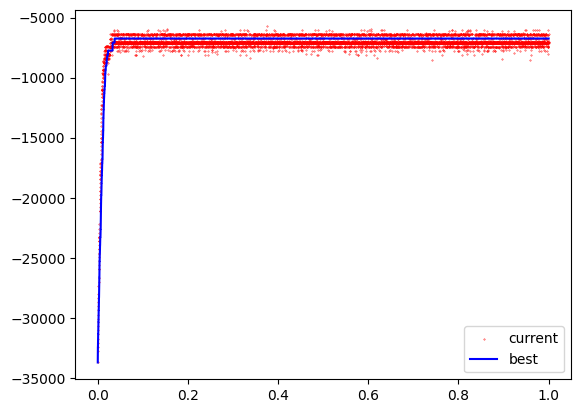

In [34]:

# Vector of all False
solution = rng.random(NUM_SETS) < 1  # Generate the initial solution
solution = numpy_to_torch_gpu(solution)  # Move solution to GPU

# Compute initial fitness
solution_fitness = fitness(solution, SETS, COSTS)

# Initialize history
full_history = [(-cost(solution, COSTS), 1)]
bettering_history = [(-cost(solution, COSTS), 1)]


tweak = multi_tweak_no_mask
for steps in tqdm(range(NSTEPS)):
    new_solution = tweak(solution)
    new_fitness = fitness(new_solution, SETS, COSTS)
    current_fitness = fitness(solution, SETS, COSTS)
    full_history.append((-cost(new_solution, COSTS), 1))
    #if the new solution is better than the current one, accept it
    # else if the acceptance probability is greater than a random number between 0 and 1,
    # accept the new solution
    if new_fitness > current_fitness:
        solution = new_solution
        bettering_history.append((-cost(new_solution, COSTS), 1))
    else:
        #put a lower bound on min temperature, that is decreasing with the number of steps
        # from 1 to 0.01
        temperature = max(0.01, 1 - steps / NSTEPS )
        # Calculate acceptance probability
        # Solution needs to be valid if the starting one was valid
        if(new_fitness[0].cpu().numpy() == current_fitness[0].cpu().numpy or new_fitness[0].cpu().numpy == True):
            acceptance_probability = np.exp((new_fitness[1].cpu().numpy() - current_fitness[1].cpu().numpy()) / temperature)
            if acceptance_probability > rng.random():
                ic("Accepted worsening solution")
                solution = new_solution
    bettering_history.append((-cost(solution, COSTS), 1))



ic(fitness(solution, SETS, COSTS))
ic(valid(solution, SETS))
# Convert full_history and bettering_history to NumPy (if they contain PyTorch tensors)
full_history_numpy = [(x[0].cpu().numpy() if isinstance(x[0], torch.Tensor) else x[0]) for x in full_history]
bettering_history_numpy = [(x[0].cpu().numpy() if isinstance(x[0], torch.Tensor) else x[0]) for x in bettering_history]

# Generate linspace for plotting
linspace_full = np.linspace(0, 1, len(full_history_numpy))  # Adjust linspace length for full history
linspace_bettering = np.linspace(0, 1, len(bettering_history_numpy))  # Adjust linspace length for bettering history

# Scatter plot for full history with reduced point size
plt.scatter(linspace_full, full_history_numpy, color='red', s=0.1)

# Line plot for bettering history
plt.plot(linspace_bettering, bettering_history_numpy, color='blue')
#build legend
plt.legend(['current', 'best'])
#save top solution as a png
file_name = 'Simulated_Annealing_' + str(UNIVERSE_SIZE) + '_' + str(NUM_SETS) + '_' + str(DENSITY) + '_' + str(NSTEPS) + '.png'
plt.savefig(file_name)
plt.show()


In [ ]:
"""
# After nsets steps of minimal improving: less than 1 unit improvement
# Get a new starting position, calculated from the last solution, with
# a powered random tweak (10 times more likely to flip a set)

def powered_tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    #temp is an invalid solution (all zeros)
    temp = np.zeros(NUM_SETS, dtype=bool)
    #Create a random mask of sets to be flipped and apply it to the solution,
    #    If the mask is True and the set is already taken -> true to false
    #    If the mask is True and the set is not taken -> false to true
    while not valid(temp):
        mask = rng.random(NUM_SETS) < 0.1
        temp = np.logical_xor(new_sol, mask)
        #if the starting solution is invalid, return tweaked one anyway
        if fitness(solution)[0] == False:
            return temp

    new_sol = temp
    return new_sol

def new_starting_position(last: np.ndarray) -> np.ndarray:
    #Returns a new starting position for the solution
    #flip a set with power_tweak
    new = powered_tweak(last)

    return new

"""

In [35]:


def powered_tweak(solution: torch.Tensor, SETS: torch.Tensor, COSTS: torch.Tensor) -> torch.Tensor:
    """Perform a powered random tweak on the solution."""
    new_sol = solution.clone()
    temp = torch.zeros(NUM_SETS, dtype=torch.bool, device=solution.device)  # Invalid solution (all zeros)

    # Create a random mask of sets to be flipped
    while not valid(temp, SETS):
        mask = torch.rand(NUM_SETS, device=solution.device) < 0.1  # Random mask with probability 0.1
        temp = torch.logical_xor(new_sol, mask)  # Apply XOR between solution and mask

        # If the starting solution is invalid, return the tweaked one anyway
        if not fitness(solution, SETS, COSTS)[0]:
            return temp

    new_sol = temp
    return new_sol


def new_starting_position(last: torch.Tensor, SETS: torch.Tensor, COSTS: torch.Tensor) -> torch.Tensor:
    """Returns a new starting position for the solution by performing powered tweak."""
    # Flip a set with powered_tweak
    new = powered_tweak(last, SETS, COSTS)
    return new


## Hill Climber with random multi mutation tweak and Iterated Local Search
Steepest step w n = 5

  0%|          | 0/10000 [00:00<?, ?it/s]

ic| "Approximated Local Minima": 'Approximated Local Minima'
    sol_n: 1
    fitness(solution, SETS, COSTS): (tensor(True, device='cuda:0'), tensor(-8657.3125, device='cuda:0'))
ic| "Approximated Local Minima": 'Approximated Local Minima'
    sol_n: 2
    fitness(solution, SETS, COSTS): (tensor(True, device='cuda:0'), tensor(-8657.3125, device='cuda:0'))
ic| "Approximated Local Minima": 'Approximated Local Minima'
    sol_n: 3
    fitness(solution, SETS, COSTS): (tensor(True, device='cuda:0'), tensor(-8657.3125, device='cuda:0'))
ic| "Approximated Local Minima": 'Approximated Local Minima'
    sol_n: 4
    fitness(solution, SETS, COSTS): (tensor(True, device='cuda:0'), tensor(-8657.3125, device='cuda:0'))
ic| "Approximated Local Minima": 'Approximated Local Minima'
    sol_n: 5
    fitness(solution, SETS, COSTS): (tensor(True, device='cuda:0'), tensor(-8657.3125, device='cuda:0'))
ic| "Approximated Local Minima": 'Approximated Local Minima'
    sol_n: 6
    fitness(solution, SETS, COS

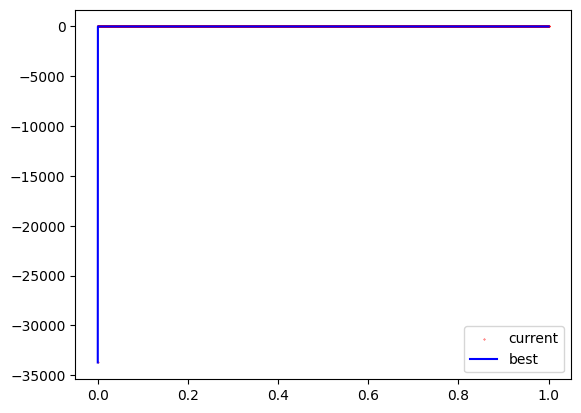

In [39]:


#How many steps to wait for a new starting position
# with NSTEPS is just a steepest step = 5
MAX_ITERATIONS = 5
CHANGE_STEPS = NSTEPS/MAX_ITERATIONS

CHANGE_COST = (np.average(COSTS.cpu().numpy())/UNIVERSE_SIZE)

# Vector of all False
solution = rng.random(NUM_SETS) < 1  # Generate the initial solution
solution = numpy_to_torch_gpu(solution)  # Move solution to GPU

# Compute initial fitness
solution_fitness = fitness(solution, SETS, COSTS)

# Initialize history
full_history = [(-cost(solution, COSTS), 1)]
bettering_history = [(-cost(solution, COSTS), 1)]

#Iterated Local search
tweak = multi_tweak_no_mask
change_quantity = []
change_steps = 0
top_solution = []


for steps in tqdm(range(NSTEPS)):
    #compute ten new solutions and take the best one

    new_solution = [tweak(solution) for _ in range(3)]
    new_solution = sorted(new_solution, key=lambda x: fitness(x, SETS, COSTS), reverse=True)[0]
    full_history.append(fitness((-cost(solution), 1))
    #if new solution is better than last one take it
    if fitness(new_solution, SETS, COSTS) > fitness(solution, SETS, COSTS):
        solution = new_solution
        change_quantity.append(-cost(new_solution, COSTS) + cost(solution, COSTS))
    else:
        change_quantity.append(0)
    change_steps += 1


    # If in the last 100 steps the improvement was less than average cost of sets
    #  get a new starting position, else remove the first cost of the vector
    #  and shift the rest of the vector to the left

    if change_steps == CHANGE_STEPS:
        if sum(change_quantity) < CHANGE_COST:
            top_solution.append(solution)
            solution = new_starting_position(solution, SETS, COSTS)
            
            change_quantity = []
            change_steps = 0
        else:
            change_quantity.pop(0)
            change_steps -= 1
    
    bettering_history.append((-cost(solution), 1))

top_solution.append(solution)
#sort top solutions for fitness
top_solution = sorted(top_solution, key=lambda x: fitness(x, SETS, COSTS), reverse=True)
sol_n = 1
for sol in top_solution:
    ic("Approximated Local Minima", sol_n, fitness(solution, SETS, COSTS))
    sol_n += 1

ic()
ic(valid(solution, SETS))
# Convert full_history and bettering_history to NumPy (if they contain PyTorch tensors)
full_history_numpy = [(x[0].cpu().numpy() if isinstance(x[0], torch.Tensor) else x[0]) for x in full_history]
bettering_history_numpy = [(x[0].cpu().numpy() if isinstance(x[0], torch.Tensor) else x[0]) for x in bettering_history]

# Generate linspace for plotting
linspace_full = np.linspace(0, 1, len(full_history_numpy))  # Adjust linspace length for full history
linspace_bettering = np.linspace(0, 1, len(bettering_history_numpy))  # Adjust linspace length for bettering history

# Scatter plot for full history with reduced point size
plt.scatter(linspace_full, full_history_numpy, color='red', s=0.1)

# Line plot for bettering history
plt.plot(linspace_bettering, bettering_history_numpy, color='blue')
#build legend
plt.legend(['current', 'best'])
#save top solution as a png

#save top solution as a png
file_name = 'Iterated_Local_Search_' + str(UNIVERSE_SIZE) + '_' + str(NUM_SETS) + '_' + str(DENSITY) + '_' + str(NSTEPS) + '.png'
plt.savefig(file_name)
plt.show()


## Hill Climbing with Iterated Local Search and Tabu search

In [ ]:

""" Not a substantial improvement, the search space is too large
#Taboo map
tabu_map = {}
tabu_map.update({hash(str(solution)): 1})
"""